# WNBA Playoffs Prediction
This notebook contains all the steps from data preparation to modeling and evaluation

In [1]:
import os
import pandas as pd
import scripts.utils as utils
import scripts.cleaning as cleaning
import scripts.visualizations as splot
import scripts.processing as processing

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load data -dictionary of dataframes
df_data = utils.load_data()
df_data11 = utils.load_data11()
df_final = pd.DataFrame()

## Data Cleaning Process

Our data cleaning process involves several steps to prepare the data for modeling, the funtions used for this project are contained in `scripts/cleaning.py`. There you can check, more detailed, what is being done but in general consists in the following steps.
   - Remove columns that are not needed for our goal or if they are just noise.
   - Sort the DataFrame by relevant columns (e.g., `year`, `playerID`, `stint`) to ensure the data is in a logical order for further processing.
   - Convert categorical values to numerical values for easier analysis and modeling.
   - convert categorical data into numerical format to better fit the algorithms requirements.
   - Create new columns based on existing data to provide additional insights.
   - Aggregate some information to have less features for training, reducing data dimensionality such as win rates..
   - Combine multiple DataFrames to create a comprehensive dataset that includes all relevant information.

In [3]:
df_data['teams'] = cleaning.clean_teams(df_data['teams'])
df_data['players'] = cleaning.clean_merge_players(df_data['players'], df_data['players_teams'])
df_data['coaches'] = cleaning.clean_coaches(df_data['coaches'])

/home/francisco/Desktop/MEIC_1YEAR/ac/WNBA_playoffs_qualification_Predictor/scripts/cleaning.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['playoff'] = df['playoff'].replace({'Y': 1, 'N': 0}).infer_objects(copy=False)
/home/francisco/Desktop/MEIC_1YEAR/ac/WNBA_playoffs_qualification_Predictor/scripts/cleaning.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['confID'] = df['confID'].replace({'EA': 1, 'WE': 0}).infer_objects(copy=False)
/home/francisco/Desktop/MEIC_1YEAR/ac/WNBA_playoffs_qualification_Predictor/scri

## Data Processing

We Will start to analyze first the players, since we have a lot of statistics of achivements of the players, we found usefull to separate and agregatte these items of what a player offered and can offer according to his position in the game. we developed a small heuristic to rate the players per year/stint.

In [4]:
print(f"Unique Postions:\n{df_data['players']['pos'].unique()} \nAttributes:\n{df_data['players'].columns}")

Unique Postions:
['G' 'F' 'C' 'G-F' 'F-C' 'C-F' 'F-G'] 
Attributes:
Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks',
       'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade',
       'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes',
       'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds',
       'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF',
       'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
       'PostthreeAttempted', 'PostthreeMade', 'PostDQ', 'pos', 'height',
       'weight', 'college', 'collegeOther', 'birthDate'],
      dtype='object')


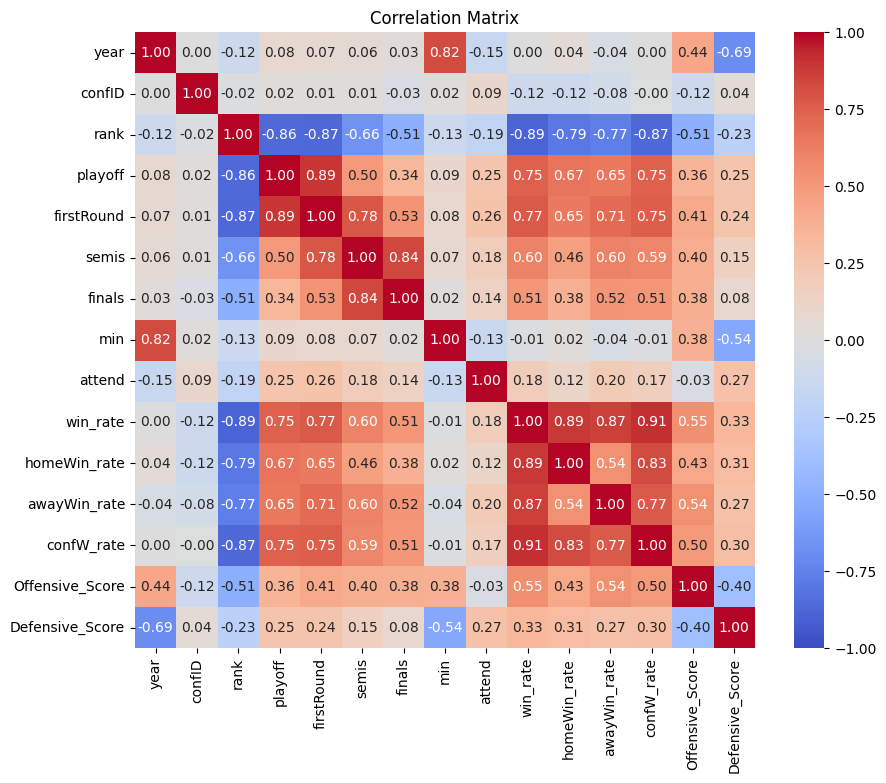

In [5]:
splot.plot_correlation_matrix(df_data['teams'])

In basketball, a player's role is largely determined by their position, which influences their contribution on the court. Our heuristic separates players into the five positional categories that exists in the dataset. Weights were also applied for specific attributes.

1. **Guards (G)**: Playmakers and Perimeter Scorers
   - **Role**: Guards typically control the game flow, create scoring opportunities, and shoot from the perimeter.
   - **Key Attributes**:
     - **Points**: Guards often score from outside, requiring a high weight for points scored.
     - **Assists**: As primary ball handlers, they facilitate scoring for teammates, making assists a critical metric.
     - **Steals**: Guards pressure opponents on defense, and steals highlight their ability to disrupt plays.
     - **Three-pointers Made**: Guards frequently take and make three-point shots, adding to their offensive value.
     - **Turnovers**: A penalty is applied because guards handle the ball most and are prone to turnovers.

2. **Forwards (F)**: Versatile Scorers and Rebounders
   - **Role**: Forwards bridge the gap between perimeter and interior play. They score, rebound, and contribute defensively.
   - **Key Attributes**:
     - **Points**: Forwards often score efficiently, so points carry a high weight.
     - **Rebounds**: Their size and positioning help them grab rebounds, critical for gaining possessions.
     - **Assists**: Forwards often facilitate offense, especially in transition plays.
     - **Blocks**: Their defensive presence in the paint adds value.
     - **Turnovers**: Penalized but less heavily than guards due to their mixed role.

3. **Centers (C)**: Interior Anchors
   - **Role**: Centers dominate near the basket, excelling in rebounding, shot-blocking, and close-range scoring.
   - **Key Attributes**:
     - **Rebounds**: Centers are crucial for securing offensive and defensive rebounds, so this is heavily weighted.
     - **Points**: Scoring is still vital, particularly in the post, and carries significant weight.
     - **Blocks**: Centers anchor the defense, with shot-blocking being a primary metric.
     - **Turnovers**: Penalized, but less critical than for guards due to lower ball-handling responsibilities.

4. **Hybrid Positions**:
   - **Guard-Forward (G-F)**: Hybrid players combine guard-like playmaking with forward-like scoring and rebounding.
     - Balanced weights reflect their dual role (e.g., scoring, assists, rebounds, and three-pointers).
   - **Forward-Center (F-C)**: Hybrid bigs blend the scoring and rebounding of a forward with the interior defense of a center.
     - Rebounds and points take precedence, while blocks and assists are also weighted.

---

- **Scoring Metrics:**
   - **Points**: Fundamental to all positions, but weights vary by role:
     - Higher for positions expected to score consistently (Guards, Forwards, Centers).
   - **Three-pointers Made**: Unique to perimeter-oriented players (Guards, G-F hybrids).

- **Playmaking Metrics:**
   - **Assists**: Essential for guards who drive the offense and secondary for forwards with facilitation roles.

- **Defensive Metrics:**
   - **Rebounds**: Vital for bigs (Centers, Forwards) who secure possessions, with lesser emphasis for guards.
   - **Steals**: Reflective of guards’ perimeter defensive pressure.
   - **Blocks**: Highlight rim protection, especially for Centers and some Forwards.

- **Turnovers:**
   - Penalized for all positions but weighted higher for guards and playmakers due to their ball-handling duties.

In [6]:
# weights inspired on John Hollinger's Player Efficiency Rating (PER) 
# https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess

# weights = {
#         'points': 85.91,      # Corresponds to FGM
#         'assists': 34.677,    # Assists weight
#         'steals': 53.897,     # Steals weight
#         'threeMade': 51.757,  # Three-pointers weight
#         'rebounds': 53.897,   # Combined offensive + defensive rebounds
#         'blocks': 39.19,      # Blocks weight
#         'turnovers': -53.897  # Turnovers weight
#     }
df_data['players'] = processing.merge_players_with_awards(df_data['players'], df_data['awards'])

weights = {
        'points': 1,      # Corresponds to FGM
        'assists': 1,    # Assists weight
        'steals': 1,     # Steals weight
        'threeMade': 1,  # Three-pointers weight
        'rebounds': 1,   # Combined offensive + defensive rebounds
        'blocks': 1,      # Blocks weight
        'turnovers': 1,  # Turnovers weight
        'awards': 5
    }


df_data['players']['RegularScore'] = df_data['players'].apply(lambda row: processing.calculate_regular_season_score(row, weights), axis=1)

# same logic but dived my number of minutes played, since the post season is shorter
df_data['players']['PostseasonScore'] = df_data['players'].apply(lambda row: processing.calculate_postseason_score(row, weights), axis=1)

df_data['players'] = df_data['players'].drop(columns=['oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 
                                                            'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 
                                                            'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 
                                                            'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 
                                                            'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 
                                                            'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 
                                                            'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])

# View the results
print(df_data['players'][['playerID', 'pos', 'RegularScore', 'PostseasonScore']])



        playerID pos  RegularScore  PostseasonScore
0     aldrima01w   G      0.067571         0.059372
1     anderke01w   G      0.109575         0.014230
2     andrame01w   F      0.349596         0.147203
3     arcaija01w   G      0.260501         0.183513
4     askamma01w   C      0.474824         0.000000
...          ...  ..           ...              ...
1871  wyckobr01w   F      0.154187         0.000000
1872  youngso01w   F      0.740412         0.257605
1873  youngta01w   F      0.040047         0.000000
1874  youngta01w   F      0.072398         0.000000
1875  zellosh01w   G      0.358075         0.279195

[1875 rows x 4 columns]


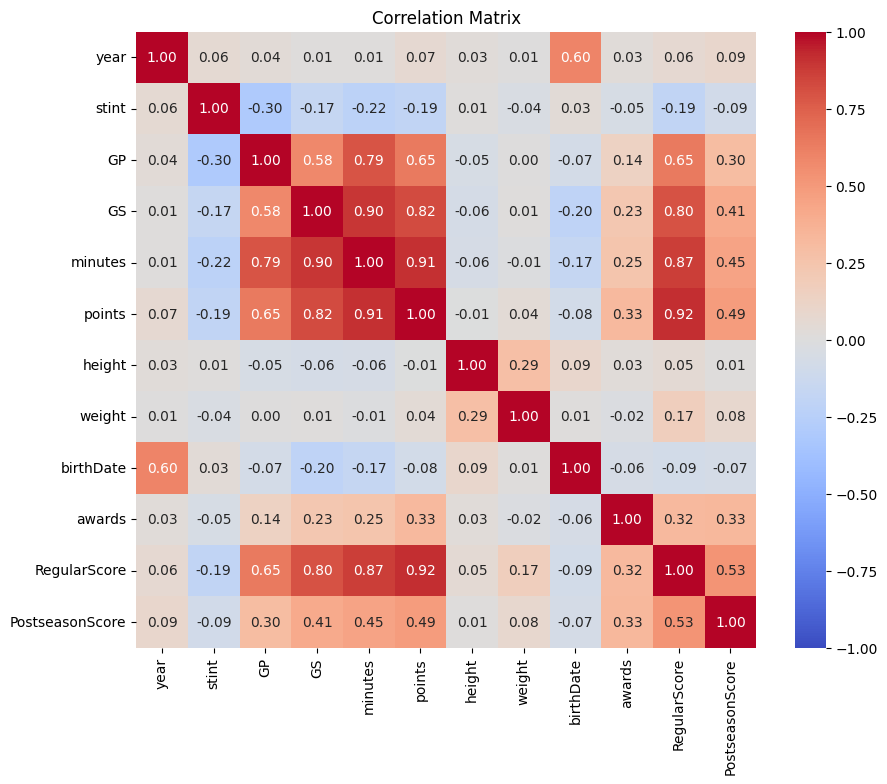

In [7]:
splot.plot_correlation_matrix(df_data['players'])

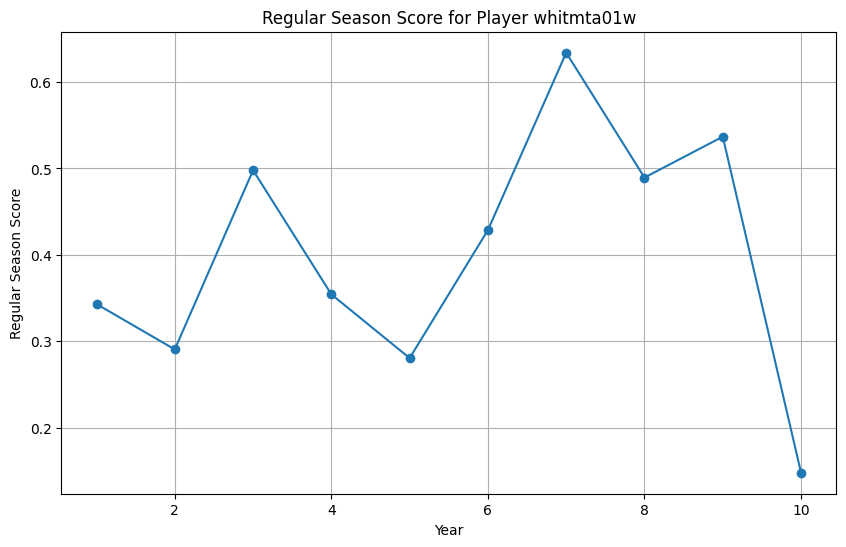

In [8]:
splot.plot_player_regular_score('whitmta01w', df_data['players'])

We find it usefull to create a new attribute with the mean of this heuristic score by team in a certain year/stint.

In [9]:
df_data['players'].head()

,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,weight,college,collegeOther,birthDate,awards,RegularScore,PostseasonScore
0,aldrima01w,1,0,WAS,29,0,272,63,G,71.0,153,UNC Charlotte,NaN,1973,0,0.067571,0.059372
1,anderke01w,1,0,WAS,30,9,434,75,G,67.0,125,Wisconsin,NaN,1974,0,0.109575,0.014230
2,andrame01w,1,0,CLE,32,18,797,265,F,71.0,165,Old Dominion,NaN,1975,0,0.349596,0.147203
3,arcaija01w,1,0,HOU,32,32,977,268,G,71.0,147,none,NaN,1969,0,0.260501,0.183513
4,askamma01w,1,0,MIA,32,32,869,251,C,77.0,198,none,NaN,1970,0,0.474824,0.000000


In [10]:
# merge df_data11['players_teams'] with our df_data['players'] on Year

df_data['players'] = pd.concat([df_data['players'], df_data11['players_teams']], ignore_index=True)

In [11]:
def shift_regular_score(group):
    # Sort by year and stint to ensure proper shifting
    group = group.sort_values(by=['year', 'stint']).reset_index(drop=True)
    
    # Create a shifted RegularScore column
    shifted_score = [0] * len(group)  # Initialize with zeros
    for i in range(len(group) - 1):
        if group.loc[i, 'stint'] == 0 and group.loc[i, 'year'] == group.loc[i + 1, 'year'] - 1:
            # Shift to the next year
            shifted_score[i + 1] = group.loc[i, 'RegularScore']
        elif group.loc[i, 'stint'] == 1 and group.loc[i + 1, 'stint'] == 2 and group.loc[i, 'year'] == group.loc[i + 1, 'year']:
            # Shift to stint 2 in the same year
            shifted_score[i + 1] = group.loc[i, 'RegularScore']
    
    group['RegularScore'] = shifted_score
    return group

df_temp = df_data['players']

# Apply the function to df_data['players']
df_data['players'] = df_temp.groupby('playerID', group_keys=False).apply(shift_regular_score)


/tmp/ipykernel_105134/1355228941.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_data['players'] = df_temp.groupby('playerID', group_keys=False).apply(shift_regular_score)


In [12]:
df_data['players'] = df_data['players'].sort_values(['year', 'playerID'])
df = df_data['players']
df

,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,weight,college,collegeOther,birthDate,awards,RegularScore,PostseasonScore,lgID
0,aldrima01w,1,0,WAS,29.0,0.0,272.0,63.0,G,71.0,153.0,UNC Charlotte,NaN,1973.0,0.0,0.000000,0.059372,NaN
0,anderke01w,1,0,WAS,30.0,9.0,434.0,75.0,G,67.0,125.0,Wisconsin,NaN,1974.0,0.0,0.000000,0.014230,NaN
0,andrame01w,1,0,CLE,32.0,18.0,797.0,265.0,F,71.0,165.0,Old Dominion,NaN,1975.0,0.0,0.000000,0.147203,NaN
0,arcaija01w,1,0,HOU,32.0,32.0,977.0,268.0,G,71.0,147.0,none,NaN,1969.0,0.0,0.000000,0.183513,NaN
0,askamma01w,1,0,MIA,32.0,32.0,869.0,251.0,C,77.0,198.0,none,NaN,1970.0,0.0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,wrighmo01w,11,0,MIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,WNBA
5,wrighta01w,11,0,SEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.407383,NaN,WNBA
4,youngso01w,11,0,SAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.740412,NaN,WNBA
3,youngta01w,11,0,CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,WNBA


In [13]:
# Reset the index of the dataframe before applying the function
df_data['players'] = df_data['players'].reset_index(drop=True)

df_data['players']['RegularScore'] = df_data['players']['RegularScore'].fillna(0)
df_data['players']['PostseasonScore'] = df_data['players']['PostseasonScore'].fillna(0)

# Apply the functions to calculate the team scores
df_data['players']['TeamScore'] = df_data['players'].apply(lambda row: processing.calculate_team_score(row, df_data['players']), axis=1)
df_data['players']['TeamPostScore'] = df_data['players'].apply(lambda row: processing.calculate_team_post_score(row, df_data['players']), axis=1)


In [14]:
df = df_data['players']
df


,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,weight,college,collegeOther,birthDate,awards,RegularScore,PostseasonScore,lgID,TeamScore,TeamPostScore
0,aldrima01w,1,0,WAS,29.0,0.0,272.0,63.0,G,71.0,153.0,UNC Charlotte,NaN,1973.0,0.0,0.000000,0.059372,NaN,0.000000,0.041859
1,anderke01w,1,0,WAS,30.0,9.0,434.0,75.0,G,67.0,125.0,Wisconsin,NaN,1974.0,0.0,0.000000,0.014230,NaN,0.000000,0.041859
2,andrame01w,1,0,CLE,32.0,18.0,797.0,265.0,F,71.0,165.0,Old Dominion,NaN,1975.0,0.0,0.000000,0.147203,NaN,0.000000,0.142983
3,arcaija01w,1,0,HOU,32.0,32.0,977.0,268.0,G,71.0,147.0,none,NaN,1969.0,0.0,0.000000,0.183513,NaN,0.000000,0.147960
4,askamma01w,1,0,MIA,32.0,32.0,869.0,251.0,C,77.0,198.0,none,NaN,1970.0,0.0,0.000000,0.000000,NaN,0.000078,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,wrighmo01w,11,0,MIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,WNBA,0.254690,0.000000
2019,wrighta01w,11,0,SEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.407383,0.000000,WNBA,0.268192,0.000000
2020,youngso01w,11,0,SAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.740412,0.000000,WNBA,0.269580,0.000000
2021,youngta01w,11,0,CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,WNBA,0.148643,0.000000


In [15]:
df_data['coaches']

,coachID,year,tmID,stint,won,lost,post_wins,post_losses,win_rate,post_win_rate,mean_win_rate,mean_post_win_rate
67,dunntr01wc,1,CHA,0,8,24,0,0,25.000000,0.0,25.000000,0.000000
82,hugheda99w,1,CLE,0,17,15,3,3,53.125000,50.0,53.125000,50.000000
106,liebena01w,1,DET,0,14,18,0,0,43.750000,0.0,43.750000,0.000000
26,chancva99w,1,HOU,0,27,5,6,0,84.375000,100.0,84.375000,100.000000
53,donovan99w,1,IND,0,9,23,0,0,28.125000,0.0,28.125000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
49,coylepa99w,10,NYL,1,6,11,0,0,35.294118,0.0,44.705882,16.666667
21,bouceje01w,10,SAC,1,3,10,0,0,23.076923,0.0,43.966817,22.222222
108,mahorri01w,10,DET,2,17,14,3,2,54.838710,60.0,54.838710,60.000000
61,donovan99w,10,NYL,2,7,10,0,0,41.176471,0.0,52.352941,28.333333


### Merging

In [ ]:
df_final = df_data['teams'].copy()

df_final.head()

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,win_rate,homeWin_rate,awayWin_rate,confW_rate,Offensive_Score,Defensive_Score
13,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,53.12,81.25,25.00,61.90,0.609431,0.464088
119,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,18.75,25.00,12.50,19.05,0.498096,0.469512
99,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,31.25,37.50,25.00,19.05,0.561561,0.450173
102,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,65.62,81.25,50.00,61.90,0.653454,0.463167
89,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,62.50,68.75,56.25,52.38,0.619434,0.489219


In [18]:
df_final

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,win_rate,homeWin_rate,awayWin_rate,confW_rate,Offensive_Score,Defensive_Score
13,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,53.12,81.25,25.00,61.90,0.609431,0.464088
119,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,18.75,25.00,12.50,19.05,0.498096,0.469512
99,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,31.25,37.50,25.00,19.05,0.561561,0.450173
102,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,65.62,81.25,50.00,61.90,0.653454,0.463167
89,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,62.50,68.75,56.25,52.38,0.619434,0.489219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,10,DET,1,3,1,1.0,0.0,-1.0,6975,136069,52.94,64.71,41.18,50.00,0.654469,0.420034
85,10,NYL,1,7,0,-1.0,-1.0,-1.0,6900,166604,38.24,47.06,29.41,40.91,0.618135,0.440320
118,10,SAS,0,4,1,0.0,-1.0,-1.0,6950,127957,44.12,58.82,29.41,50.00,0.660863,0.421821
52,10,IND,1,1,1,1.0,1.0,0.0,6925,134964,64.71,82.35,47.06,77.27,0.635741,0.447085


# Training

Defining the target value as playoff_next_season

In [19]:
df_final = df_final.sort_values(['tmID', 'year'])

df_final['playoff_next_season'] = df_final.groupby('tmID')['playoff'].shift(-1)

df_final['playoff_next_season'] = df_final.apply(
    lambda row: row['playoff_next_season'] if row['year'] == 10 else (0 if pd.isna(row['playoff_next_season']) else row['playoff_next_season']),
    axis=1
)

Defining the features to be used by the model

In [20]:
features = [
    'year', 'tmID', 'rank', 'playoff', 'firstRound', 'semis', 'finals',
    'win_rate', 'Offensive_Score', 'Defensive_Score','last_3_years_history',
    'squad_post_performance', 'squad_performance', 'awards_players',
    'coaches_win_rate', 'coaches_post', 'coaches_history',	'coaches_history_pos', 'team_lore'
    ]
# exist some features that are not yet created, they are defined in the next cells
# 'coach_score'
target = 'playoff_next_season'

Choosing the alghoritm

In [21]:

df_final.to_csv('data/df_final.csv', index=False)

In [22]:
def shift_team_attributes(df_final, df_data11):
    # Define default values for new teams
    default_values = {
        'rank': 9, 'playoff': 0, 'firstRound': -1, 'semis': -1, 'finals': -1,
        'min': 0, 'attend': 0, 'win_rate': 10, 'homeWin_rate': 10, 'awayWin_rate': 10,
        'confW_rate': 0, 'Offensive_Score': 0.4, 'Defensive_Score': 0.3,
        'playoff_next_season': 0, 'confID': None
    }

    # Prepare the output dataframe
    shifted_data = []

    # Iterate over years
    for year in sorted(df_final['year'].unique()):
        current_year_data = df_final[df_final['year'] == year]

        if year < 10:
            next_year_teams = df_final[df_final['year'] == year + 1]['tmID'].unique()
        elif year == 10:
            next_year_teams = df_data11['tmID'].unique()
        else:
            continue

        # Map current year teams to next year
        next_year_mapping = {tmID: tmID for tmID in next_year_teams if tmID in current_year_data['tmID'].values}

        # Add new teams to the mapping with default values
        for tmID in next_year_teams:
            if tmID not in next_year_mapping:
                next_year_mapping[tmID] = None

        # Process each team in the mapping
        for next_tmID, current_tmID in next_year_mapping.items():
            if current_tmID:
                team_data = current_year_data[current_year_data['tmID'] == current_tmID].iloc[0].to_dict()
            else:
                # Get the conference for the new team from df_data11
                confID_value = df_data11[df_data11['tmID'] == next_tmID]['confID'].iloc[0] if not df_data11[df_data11['tmID'] == next_tmID].empty else None
                # Set the default values for new teams
                team_data = default_values.copy()
                # Set the confID value for new teams
                if confID_value == 'EA':
                    team_data['confID'] = 1
                elif confID_value == 'WE':
                    team_data['confID'] = 0
                else:
                    team_data['confID'] = None

            # Update team data for the next year
            team_data['year'] = year + 1
            team_data['tmID'] = next_tmID
            shifted_data.append(team_data)

    # Create the final dataframe
    return pd.DataFrame(shifted_data)


df_final = shift_team_attributes(df_final, df_data11['teams'])
df_final

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,win_rate,homeWin_rate,awayWin_rate,confW_rate,Offensive_Score,Defensive_Score,playoff_next_season
0,2,CHA,1,8,0,-1.0,-1.0,-1.0,6475,90963,25.00,31.25,18.75,23.81,0.615615,0.433523,1.0
1,2,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,53.12,81.25,25.00,61.90,0.609431,0.464088,1.0
2,2,DET,1,5,0,-1.0,-1.0,-1.0,6425,107289,43.75,50.00,37.50,47.62,0.605842,0.431452,0.0
3,2,HOU,0,2,1,1.0,1.0,1.0,6475,196077,84.38,87.50,81.25,80.95,0.661240,0.493888,1.0
4,2,IND,1,7,0,-1.0,-1.0,-1.0,6425,180270,28.12,31.25,25.00,33.33,0.600887,0.453142,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,11,PHO,0,1,1,1.0,1.0,1.0,6900,144884,67.65,70.59,64.71,65.00,0.740691,0.391339,NaN
134,11,SAS,0,4,1,0.0,-1.0,-1.0,6950,127957,44.12,58.82,29.41,50.00,0.660863,0.421821,NaN
135,11,SEA,0,2,1,0.0,-1.0,-1.0,7025,133858,58.82,76.47,41.18,65.00,0.630925,0.442717,NaN
136,11,WAS,1,4,1,0.0,-1.0,-1.0,6875,192747,47.06,64.71,29.41,45.45,0.594502,0.418142,NaN


In [23]:
df_final = processing.merge_players(df_final, df_data['players'])
df_final = processing.merge_coaches(df_final, df_data['coaches'])
df_final = processing.calculate_last_3_years_history(df_final)
df_final = processing.calculate_team_lore(df_final)

df_final

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,...,playoff_next_season,squad_post_performance,squad_performance,awards_players,coaches_win_rate,coaches_post,coaches_history,coaches_history_pos,last_3_years_history,team_lore
0,2,CHA,1,8,0,-1.0,-1.0,-1.0,6475,90963,...,1.0,0.186884,0.178229,0.0,56.250,50.000000,42.1875,25.000000,0.178229,909.790406
1,2,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,...,1.0,0.060641,0.176111,0.0,68.750,33.333333,60.9375,41.666667,0.176111,1375.4785
2,2,DET,1,5,0,-1.0,-1.0,-1.0,6425,107289,...,0.0,0.000000,0.175466,0.0,31.250,0.000000,31.2500,0.000000,0.175466,1073.04792
3,2,HOU,0,2,1,1.0,1.0,1.0,6475,196077,...,1.0,0.052391,0.139708,1.0,59.375,0.000000,71.8750,50.000000,0.139708,1961.095737
4,2,IND,1,7,0,-1.0,-1.0,-1.0,6425,180270,...,0.0,0.000000,0.191177,0.0,31.250,0.000000,31.2500,0.000000,0.191177,1802.872059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,11,PHO,0,1,1,1.0,1.0,1.0,6900,144884,...,NaN,0.000000,0.215622,0.0,NaN,NaN,NaN,NaN,0.207275,1804.222285
134,11,SAS,0,4,1,0.0,-1.0,-1.0,6950,127957,...,NaN,0.000000,0.269580,0.0,NaN,NaN,NaN,NaN,0.246915,1615.556894
135,11,SEA,0,2,1,0.0,-1.0,-1.0,7025,133858,...,NaN,0.000000,0.268192,0.0,NaN,NaN,NaN,NaN,0.221257,1688.692067
136,11,WAS,1,4,1,0.0,-1.0,-1.0,6875,192747,...,NaN,0.000000,0.190185,0.0,NaN,NaN,NaN,NaN,0.184172,2304.578305


In [29]:
df_final.columns

Index(['year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis',
       'finals', 'min', 'attend', 'win_rate', 'homeWin_rate', 'awayWin_rate',
       'confW_rate', 'Offensive_Score', 'Defensive_Score',
       'playoff_next_season', 'last_3_years_history', 'squad_post_performance',
       'squad_performance', 'awards_players', 'coaches_win_rate',
       'coaches_post', 'coaches_history', 'coaches_history_pos', 'team_lore'],
      dtype='object')

In [ ]:
YEAR = 11

train_data = df_final[df_final['year'] < YEAR]
test_data = df_final[df_final['year'] == YEAR]

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# , 'confID'
categorical_features = ['tmID']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep other features as is
)

#Build pipeline with preprocessing and classifier
clf = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('classifier', RandomForestClassifier(random_state=42))
])

#Train the Model
clf.fit(X_train, y_train)

/home/francisco/pythonEnv/ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['tmID'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Predicting and evaluating:

In [36]:
import numpy as np

# Predict on the test data using the pipeline
test_data['predicted_playoff_next_season'] = clf.predict(X_test)

# Get probabilities for class 1
probas = clf.predict_proba(X_test)[:, 1]

# Add the probabilities to the test_data DataFrame
test_data.loc[:, 'playoff_probability'] = probas


def normalize_probabilities(group):
    # Min-max scaling to ensure values are between 0 and 1
    max_prob = group['playoff_probability'].max()
    min_prob = group['playoff_probability'].min()
    if max_prob != min_prob:  # Avoid division by zero for constant probabilities
        group['playoff_probability'] = (group['playoff_probability'] - min_prob) / (max_prob - min_prob)
    else:
        group['playoff_probability'] = 1  # All values are the same
    
    # Scale probabilities so the sum is at most 4
    total_prob = group['playoff_probability'].sum()
    if total_prob > 0:  # Avoid division by zero
        group['playoff_probability'] *= (4 / total_prob)
    
    # Ensure no value exceeds 1 after scaling
    group['playoff_probability'] = group['playoff_probability'].clip(upper=1)
    
    return group

# Apply normalization by confID
test_data = test_data.groupby('confID').apply(normalize_probabilities).reset_index(drop=True)

# Ensure the top 8 teams are selected for playoffs
test_data = test_data.sort_values(by='playoff_probability', ascending=False)

# Assign playoff decision to top 8 teams
test_data.loc[:, 'final_playoff_decision'] = 0
test_data.iloc[:8, test_data.columns.get_loc('final_playoff_decision')] = 1

# Final output 'year', 'predicted_playoff_next_season',
output = test_data[['tmID', 'final_playoff_decision', 'playoff_probability', 'confID']]
print(output)

   tmID  final_playoff_decision  playoff_probability  confID
9   IND                       1             1.000000       1
6   ATL                       1             1.000000       1
0   LAS                       1             0.941176       0
4   SEA                       1             0.941176       0
2   PHO                       1             0.764706       0
3   SAS                       1             0.705882       0
1   MIN                       1             0.647059       0
7   CHI                       1             0.160000       1
10  NYL                       0             0.160000       1
5   TUL                       0             0.000000       0
8   CON                       0             0.000000       1
11  WAS                       0             0.000000       1


/tmp/ipykernel_105134/529404015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_playoff_next_season'] = clf.predict(X_test)
/tmp/ipykernel_105134/529404015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'playoff_probability'] = probas
/tmp/ipykernel_105134/529404015.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

### THE FOLLOWING ACCURACYS/error, in the cells behind this comment, Are not FROM YEAR 11, they were for year 10

In [33]:
# I want to compare now the final_playoff_decision with the playoff_next_season

# Calculate the accuracy of the playoff prediction
accuracy = (test_data['playoff_next_season'] == test_data['final_playoff_decision']).mean()
# Iterate through rows and use the `team` variable (a Series for each row)
for _, team in test_data.iterrows():
    # print(f" {team['tmID']}: REAL: {team['playoff_next_season']} PRED:  {team['final_playoff_decision']}  -  BOOL: {team['playoff_next_season'] == team['final_playoff_decision']}")
    print(f" {team['tmID']}: REAL: {team['playoff_next_season']} PRED:  {team['final_playoff_decision']}  -  BOOL: {team['playoff_next_season'] == team['final_playoff_decision']}")

# Display the accuracy
print(f"Accuracy of playoff prediction: {accuracy:.2f}")

 LAS: REAL: 1.0 PRED:  1  -  BOOL: True
 IND: REAL: 1.0 PRED:  1  -  BOOL: True
 PHO: REAL: 1.0 PRED:  1  -  BOOL: True
 SEA: REAL: 1.0 PRED:  1  -  BOOL: True
 DET: REAL: 1.0 PRED:  1  -  BOOL: True
 SAS: REAL: 1.0 PRED:  1  -  BOOL: True
 ATL: REAL: 1.0 PRED:  1  -  BOOL: True
 WAS: REAL: 1.0 PRED:  1  -  BOOL: True
 CON: REAL: 0.0 PRED:  0  -  BOOL: True
 NYL: REAL: 0.0 PRED:  0  -  BOOL: True
 SAC: REAL: 0.0 PRED:  0  -  BOOL: True
 MIN: REAL: 0.0 PRED:  0  -  BOOL: True
 CHI: REAL: 0.0 PRED:  0  -  BOOL: True
Accuracy of playoff prediction: 1.00


In [34]:
error = abs(test_data['playoff_probability']-test_data['playoff_next_season']).sum()
print(f"Error: {error:.2f}")

Error: 1.43
